In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

# Data Loading

In [3]:
# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "/content/gdrive/MyDrive/Kaggle/handwriting-recognition.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	#zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

Extracting all the files now...
Done!


# Data Preprocessing

In [4]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')
train.sort_values(by='FILENAME',inplace=True)
valid.sort_values(by='FILENAME',inplace=True)


In [5]:
data_dir_train = Path('./train_v2/train/')
data_dir_valid = Path('./validation_v2/validation/')

train['IMAGE'] = sorted(list(map(str,list(data_dir_train.glob('*.jpg')))))
valid['IMAGE'] = sorted(list(map(str,list(data_dir_valid.glob('*.jpg')))))

In [6]:
train.dropna(axis=0,inplace=True)
valid.dropna(axis=0,inplace=True)

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

train.reset_index(inplace=True,drop=True)
valid.reset_index(inplace=True,drop=True)

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
valid['Length']=valid['IDENTITY'].apply(lambda x : len(str(x)))

train = train[train['Length']<=21]
valid = valid[valid['Length']<=21]

In [7]:
train = train[:50000]
valid = valid[:5000]
len(train)

50000

In [8]:
images_train = train['IMAGE'].values
images_valid = valid['IMAGE'].values


labels_train = []
labels_valid = []
for i in train['IDENTITY']:
  if len(i)<21:
    i+='#'*(21-len(i))
  labels_train.append(i)

for i in valid['IDENTITY']:
  if len(i)<21:
    i+='#'*(21-len(i))
  labels_valid.append(i)

#labels_train = train['IDENTITY']
#labels_valid = valid['IDENTITY']

characters = set(char for label in labels_train for char in label)

print("Number of train images found: ", len(images_train))
print("Number of train labels found: ", len(labels_train))
print("Number of validation images found: ", len(images_valid))
print("Number of validation labels found: ", len(labels_valid))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

img_width = 256
img_height = 64
batch_size = 128

downsample_factor = 4
max_length = 22

Number of train images found:  50000
Number of train labels found:  50000
Number of validation images found:  5000
Number of validation labels found:  5000
Number of unique characters:  30
Characters present:  {' ', 'T', 'N', 'V', 'B', 'Z', 'E', 'K', 'M', 'Y', 'W', 'I', 'A', '#', 'P', 'G', 'Q', '-', 'C', 'H', 'X', 'S', "'", 'D', 'F', 'L', 'O', 'J', 'U', 'R'}


In [9]:
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary=sorted(list(characters)),
                                                             num_oov_indices=0,
                                                             mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                                             mask_token=None,
                                                             invert=True)

In [10]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #label = char_to_index(label)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((images_valid, labels_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

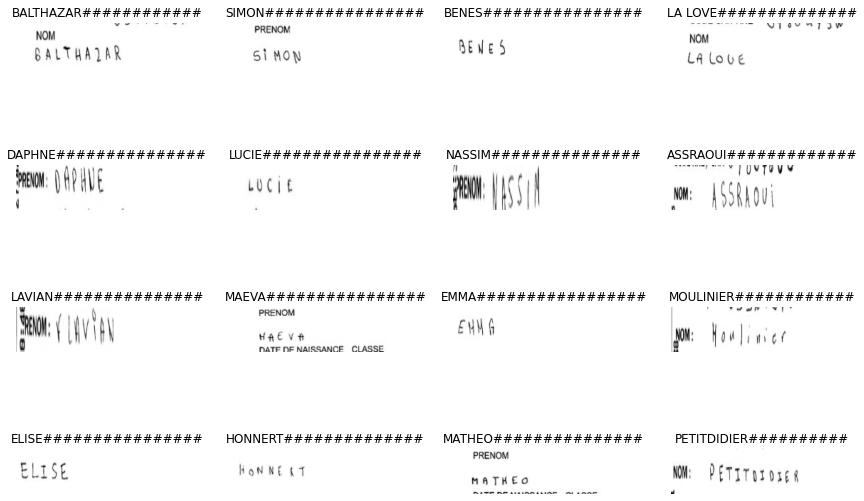

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Model

In [ ]:
class CTCLayer(layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0] , dtype = 'int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len,1), dtype = 'int64')
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')
    loss = self.loss_fn(y_true,y_pred,input_length,label_length)
    self.add_loss(loss)
    return y_pred

In [ ]:
def build_model():
  #Input
  inputs = keras.Input(shape=(img_width,img_height,1), name='image', dtype=tf.float32)
  labels = keras.Input(shape=(None,),name='label',dtype=tf.float32)

  # First Conv1 Block
  x = layers.Conv2D(64,
                    (3,3),
                    padding='same',
                    activation='relu',
                    kernel_initializer='he_normal',
                    name='Conv1')(inputs)
  x = layers.MaxPool2D((2,2),name='pool1')(x)
  x = layers.Dropout(0.2)(x)
  # Second Conv2 Block
  x = layers.Conv2D(128,
                    (3,3),
                    padding='same',
                    kernel_initializer='he_normal',
                    activation='relu',
                    name='Conv2')(x)
  x = layers.MaxPool2D((2,2),name='pool2')(x)
  x = layers.Dropout(0.2)(x)

  new_shape = ((img_width//4),(img_height//4)*128)
  x = layers.Reshape(target_shape=new_shape,name='reshape')(x)
  x = layers.Dense(64,activation='relu',name='dense1')(x)
  x = layers.Dropout(0.2)(x)

  #RNN
  x = layers.Bidirectional(layers.LSTM(128,return_sequences=True,dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64,return_sequences=True,dropout=0.25))(x)

  x = layers.Dense(len(characters)+1,activation='softmax',name='dense2')(x)

  # CTC Layer
  outputs = CTCLayer(name='ctc_loss')(labels,x)

  # model
  model = keras.models.Model(inputs=[inputs,labels], outputs=outputs, name='ocr_model_v1')

  # Optimizer
  optimizer = keras.optimizers.Adam()

  # compile model
  model.compile(optimizer=optimizer)

  return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 64, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 32, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 32, 64)  0           pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/100
391/391 [==============================] - 120s 209ms/step - loss: 33.5404 - val_loss: 25.7112
Epoch 2/100
391/391 [==============================] - 77s 195ms/step - loss: 21.1120 - val_loss: 27.1297
Epoch 3/100
391/391 [==============================] - 76s 195ms/step - loss: 20.3901 - val_loss: 30.6220
Epoch 4/100
391/391 [==============================] - 76s 193ms/step - loss: 19.5157 - val_loss: 18.3746
Epoch 5/100
391/391 [==============================] - 76s 194ms/step - loss: 18.2770 - val_loss: 16.9787
Epoch 6/100
391/391 [==============================] - 76s 195ms/step - loss: 16.8295 - val_loss: 15.1893
Epoch 7/100
391/391 [==============================] - 76s 194ms/step - loss: 15.0057 - val_loss: 12.5708
Epoch 8/100
391/391 [==============================] - 76s 195ms/step - loss: 16.1587 - val_loss: 12.0076
Epoch 9/100
391/391 [==============================] - 76s 194ms/step - loss: 12.9094 - val_loss: 10.7662
Epoch 10/100
391/391 [=======================

In [ ]:
model.save('/content/gdrive/MyDrive/Handwriten_Recognitin/model2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Handwriten_Recognitin/model2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Handwriten_Recognitin/model2/assets


In [ ]:
prediction_model = keras.models.Model(
    model.get_layer('image').input, model.get_layer('dense2').output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0     

In [ ]:
prediction_model.save('/content/gdrive/MyDrive/Handwriten_Recognition/predtion_model_2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Handwriten_Recognition/predtion_model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Handwriten_Recognition/predtion_model_2/assets


In [19]:
pred_model = keras.models.load_model('/content/gdrive/MyDrive/Handwriten_Recognition/predtion_model_2',compile = False)

In [ ]:
pred_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0     

In [12]:
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  
  results = keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0][:,:max_length]
  output_text = []

  for res in results:
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('UTF-8')
    res = res.split('#')[0]
    output_text.append(res)
  return output_text

# Testing Model

In [13]:
test = pd.read_csv('/content/written_name_test_v2.csv')
test.sort_values(by='FILENAME', inplace=True)

data_dir_test = Path('./test_v2/test/')
test['IMAGE'] = sorted(list(map(str,list(data_dir_test.glob('*.jpg')))))
test = test[:5000]

In [14]:
test.dropna(axis=0,inplace=True)

test = test[test['IDENTITY'] != 'UNREADABLE']
test.reset_index(drop=True,inplace=True)
test['LENGTH'] = test['IDENTITY'].apply(lambda x: len(str(x)))
test = test[test['LENGTH'] <=21]
images_test = test['IMAGE'].values
labels_test = []
for i in test['IDENTITY']:
  if len(i)<21:
    i+='#'*(21-len(i))
  labels_test.append(i)

In [15]:
test

,FILENAME,IDENTITY,IMAGE,LENGTH
0,TEST_0001.jpg,KEVIN,test_v2/test/TEST_0001.jpg,5
1,TEST_0002.jpg,CLOTAIRE,test_v2/test/TEST_0002.jpg,8
2,TEST_0003.jpg,LENA,test_v2/test/TEST_0003.jpg,4
3,TEST_0004.jpg,JULES,test_v2/test/TEST_0004.jpg,5
4,TEST_0005.jpg,CHERPIN,test_v2/test/TEST_0005.jpg,7
...,...,...,...,...
4984,TEST_13632.jpg,ANTOINE,test_v2/test/TEST_13632.jpg,7
4985,TEST_13633.jpg,MARGAUX,test_v2/test/TEST_13633.jpg,7
4986,TEST_13634.jpg,BELKAID,test_v2/test/TEST_13634.jpg,7
4987,TEST_13635.jpg,FOLLANA,test_v2/test/TEST_13635.jpg,7


In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

In [20]:
pred_label = []
true_label = []
for sample in test_dataset:
  imgs = sample['image'] 
  lbls = sample['label']
  
  pred = pred_model.predict(imgs)
  pred = decode_batch_prediction(pred)
  pred_label.extend(pred)
  
  for label in lbls:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
    label = label.split('#')[0]
    true_label.append(label)
    #print(label)

In [21]:
df = pd.DataFrame({'True_Label':true_label,'Pred_label':pred_label })

In [22]:
df

,True_Label,Pred_label
0,KEVIN,KEVIN
1,CLOTAIRE,CEOT
2,LENA,LENA
3,JULES,JULES
4,CHERPIN,CHERPIN
...,...,...
4984,ANTOINE,ANTOINE
4985,MARGAUX,MARGAUX
4986,BELKAID,BELKAID
4987,FOLLANA,FOLLANA


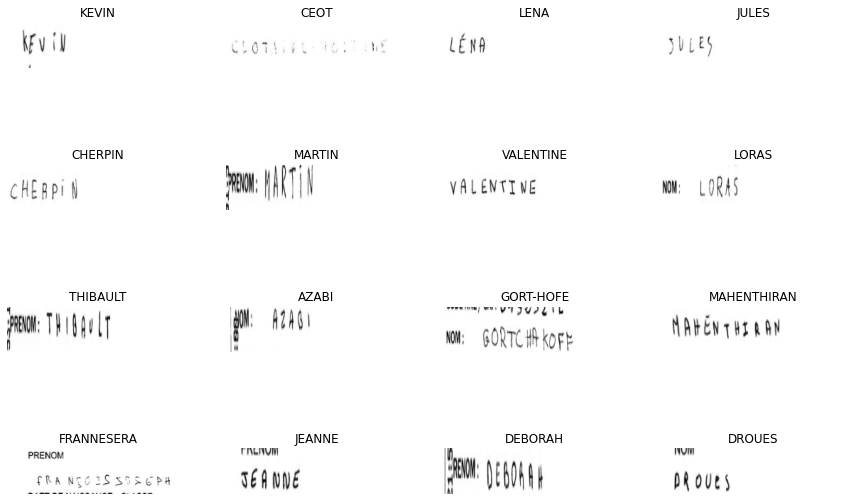

In [23]:
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in test_dataset.take(1):
    images = batch["image"]
    labels = pred_label[:batch_size]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(labels[i])
        ax[i // 4, i % 4].axis("off")
plt.show()